At the end of the notebook there is a piece of code to upload the model and its losses

Import of the needed libraries

In [8]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
from IPython.display import clear_output
import matplotlib.pyplot as plt
import copy
from IPython.display import clear_output
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import random

Readimg the anonymized data, the full dataset and a chosen item that will be evaluated after the training

In [9]:
data_num = pd.read_csv('data_num_emea.csv')
data_num.set_index("Week", inplace = True)

forecast_num = pd.read_csv('forecast_num_emea.csv')
forecast_num.set_index("Week", inplace = True)

Split the data into train and test and input(X) and output(y)

In [98]:
combined_df = pd.concat([data_num, forecast_num[:-52]])

##
train = combined_df[combined_df['Year'] != 2023]
test = combined_df[combined_df['Year'] == 2023]

##
X_train = train.drop(columns=['Demand'])
y_train = train['Demand']
X_test = test.drop(columns=['Demand'])
y_test = test['Demand']
##

forecast_num_last52 = forecast_num[-52:]

X_forecast  = forecast_num_last52.drop(columns=['Demand'])
y_forecast = forecast_num_last52['Demand']

y_dem = forecast_num[:-52]
y_dem = y_dem['Demand']


### Pre Processing

Process the data to be used with our models:

    - It is scaled to standardize features by removing the mean and scaling to unit variance

    - Transform the data into tensors from the torch library, same library that is used to build the models
    
    - Then prepare the data into DataLoaders to be used with the models

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_forecast_scaled = scaler.transform(X_forecast)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

##
X_val_tensor = torch.tensor(X_test_scaled.astype(np.float32))
y_val_tensor = torch.tensor(y_test.values.astype(np.float32))
##

X_forecast_tensor = torch.tensor(X_forecast_scaled, dtype=torch.float32)

# Create Data Loaders

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

##
val_data = TensorDataset(X_val_tensor, y_val_tensor)
##

forecast_data = TensorDataset(X_forecast_tensor)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

##
val_loader = DataLoader(val_data, batch_size=128)
##

forecast_loader = DataLoader(forecast_data, batch_size=128, shuffle=False)

Apply the manual weights that after some trials, seem to work better.

In [13]:
manual_weights = {
     'SKU': 1.0,
     'Week': 1.0,
     'Region': 1.0,
     'Global Status': 1.0,
     'DNA Collection ': 1.0,
     'DNA Category ': 1.5, #
     'DNA Sub Category ': 1.5, #
     'DNA Metal ': 1.5, #
     'DNA Material ': 1.5, #
     'DNA Stones ': 1.5, #
     'DNA Color ': 1.5, #
     'DNA Size ': 1.5, #
     'Date Item Introduced': 1.0,
     'Date Item Discontinue': 1.0,
     'Design Variation': 2.5, #
     'Campaign Id': 2.0,
     'Theme Id': 1.0,
     'Theme Description': 1.0,
     'Year': 2.0,
     'Week_Number': 2.0,
     'Seasonality': 4.0,
     'Evolving State': 4.0,
     'Buckets': 1.0
 }

manual_weights_transformers = manual_weights

manual_weights_LSTM = manual_weights

Implementation of the differnt weights to the input data features

In [15]:
class ManualFeatureAttention(nn.Module):
    def __init__(self, num_features, feature_names, manual_weights):
        super(ManualFeatureAttention, self).__init__()
        self.num_features = num_features
        self.feature_names = feature_names
        self.manual_weights = manual_weights

        # Initialize attention weights
        self.attention_weights = nn.Parameter(torch.ones(num_features))

        # Manually adjust weights for specified features
        for i, feature_name in enumerate(feature_names):
            if feature_name in manual_weights:
                self.attention_weights.data[i] = manual_weights[feature_name]

    def forward(self, x):
        # Dynamically resize attention weights if necessary
        if x.size(1) != self.attention_weights.size(0):
            # Resize attention weights to match input size
            # Note: This resizing strategy should be carefully chosen
            self.attention_weights = nn.Parameter(torch.ones(x.size(1)))
        
        # Apply attention weights
        x = x * self.attention_weights
        return x

Tool that saves the model when it gives the lowest validation loss and stops the training of the model after x amount of increases of the validation loss, depending on a patience that has to be set, to avoid unnecessary training of the model.

In [14]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

### Models

#### Transformers Model

Description of the Transformers model with a batch size of 128 because converged faster to the final result

Also defning the diferent dropout values depending on the layer

In [80]:
# Transformers Model
class NeuralNetWithManualAttention(nn.Module):
    def __init__(self, num_features, feature_names, manual_weights, num_past_weeks):
        super(NeuralNetWithManualAttention, self).__init__()
        
        ###########
        self.num_past_weeks = num_past_weeks

        # Conv1D Layer for Time Series
        self.conv1 = nn.Conv1d(in_channels=num_past_weeks, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        ###########

        self.feature_attention = ManualFeatureAttention(num_features, feature_names, manual_weights)
        #
        # Adjust the input size of the first linear layer
        self.layer1 = nn.Linear(num_features * 32, 128)  # Adjusted input size
        ##
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.25)             
        self.layer2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.25)             
        self.layer3 = nn.Linear(64, 32)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.1)             
        self.layer4 = nn.Linear(32, 16)
        self.batch_norm4 = nn.BatchNorm1d(16)
        self.dropout4 = nn.Dropout(0.1)            

        # Final layer
        self.final_layer = nn.Linear(16, 1)
    
    def forward(self, x):
        # Store the original batch size for later use
        original_batch_size = x.size(0)

        # Padding to 24 features
        padding_size = 24 - x.size(1)
        if padding_size > 0:
            pad = torch.zeros(original_batch_size, padding_size).to(x.device)
            x = torch.cat([x, pad], dim=1)

        # Now x has 24 features, reshape considering 4 weeks
        x = x.view(original_batch_size, self.num_past_weeks, -1)

        # Process time series data with Conv1D
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))

        # Flatten and feed into the rest of the network
        x = x.view(original_batch_size, -1)

        # Calculate the size of the flattened features
        flattened_size = x.size(1)

        # Adjust the first linear layer to match the flattened size
        if self.layer1.in_features != flattened_size:
            self.layer1 = nn.Linear(flattened_size, 128).to(x.device)

        # Apply the feature attention
        x = self.feature_attention(x)

        # Process through the remaining layers
        x = self.dropout1(nn.functional.elu(self.batch_norm1(self.layer1(x)), 0.01))
        x = self.dropout2(nn.functional.elu(self.batch_norm2(self.layer2(x)), 0.01))
        x = self.dropout3(nn.functional.elu(self.batch_norm3(self.layer3(x)), 0.01))
        x = self.dropout4(nn.functional.elu(self.batch_norm4(self.layer4(x)), 0.01))

        x = self.final_layer(x)

        return x


# Create model instance
model_transformers = NeuralNetWithManualAttention(X_train_tensor.shape[1], X_train.columns, manual_weights_transformers, num_past_weeks=4)


#### LSTM Custom Model

LSTM implementation with dynamic dropout values

In [81]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rates):
        super(CustomLSTM, self).__init__()
        self.num_layers = num_layers
        # Initialize LSTM cells
        self.lstm_cells = nn.ModuleList([nn.LSTMCell(input_size if i == 0 else hidden_size, hidden_size) for i in range(num_layers)])
        # Dropout layers with different probabilities
        self.dropouts = nn.ModuleList([nn.Dropout(p=dropout_rates[i]) for i in range(num_layers - 1)])
        self.dropout_final = nn.Dropout(p=dropout_rates[-1])
        
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        # Initialize hidden and cell states
        h_t = [torch.zeros(batch_size, self.lstm_cells[i].hidden_size).to(x.device) for i in range(self.num_layers)]
        c_t = [torch.zeros(batch_size, self.lstm_cells[i].hidden_size).to(x.device) for i in range(self.num_layers)]
        
        # Collect outputs at each time step
        outputs = []

        # Process the sequence
        for t in range(seq_len):
            x_t = x[:, t, :]
            for i, (cell, dropout) in enumerate(zip(self.lstm_cells, self.dropouts + [self.dropout_final])):
                h_t[i], c_t[i] = cell(x_t, (h_t[i], c_t[i]))
                x_t = dropout(h_t[i]) if i < self.num_layers - 1 else h_t[i]
                if i == self.num_layers - 1:  # Only collect output from the final layer
                    outputs.append(x_t.unsqueeze(1))
        
        # Concatenate outputs along the time step dimension
        outputs = torch.cat(outputs, dim=1)

        # Return the outputs and the final hidden state
        return outputs, h_t[-1]

In [82]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, num_features, feature_names, manual_weights, hidden_size, num_layers, dropout_rates):

        super(LSTMModel, self).__init__()
        self.feature_attention = ManualFeatureAttention(num_features, feature_names, manual_weights)
        
        # Using CustomLSTM instead of nn.LSTM
        self.lstm = CustomLSTM(input_size=num_features, hidden_size=hidden_size, num_layers=num_layers, dropout_rates=dropout_rates)
        
        # Additional intermediate dense layer with ReLU activation
        self.intermediate_linear = nn.Linear(hidden_size, hidden_size * 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.15) # Intermediate layer
        
        # Output layer
        self.output_linear = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        x = self.feature_attention(x)
        _, hidden = self.lstm(x)  
        
        x = hidden
        
        # Passing through the intermediate dense layer with ReLU activation and dropout
        x = self.dropout(self.relu(self.intermediate_linear(x)))

        # Final output layer
        x = self.output_linear(x)
        
        x = x.squeeze()  # Change shape from [batch_size, 1] to [batch_size]
        
        return x
    
# Model parameters
input_dim = X_train.shape[1]
hidden_dim = 18
layer_dim = 4
output_dim = 1

# Correctly defined feature names from the DataFrame
feature_names = combined_df.columns.tolist()
feature_names.remove('Demand')

# Set your custom dropout rates for each layer
custom_dropout_rates = [0.15, 0.1, 0.1, 0.05]  # For example, for a 4-layer LSTM

model_LSTM = LSTMModel(num_features=len(feature_names), feature_names=feature_names ,manual_weights=manual_weights_LSTM, hidden_size=hidden_dim, num_layers=layer_dim, dropout_rates=custom_dropout_rates)

#### ARIMA

ARIMA model definition, obust model to compare with the new models

In [76]:
def ARIMA(data=forecast_num):
    data = data.copy(deep=True)
    data.reset_index(drop=True)
    # Dictionary to store results
    results = {}

    # ARIMA Order
    p, d, q = 1, 1, 1

    # Seasonal Order
    P, D, Q, m = 1, 1, 1, 52 

    for sku, subgroup in data.groupby('SKU'):
        
        results[sku] = {}

        for dc, group in subgroup.groupby('Region'):
            results[sku][dc] = {}

            # Fit auto_arima function to the dataset
            stepwise_fit = auto_arima(group['Demand'], start_p=1, start_q=1,
                                      max_p=2, max_q=2, m=m,
                                      start_P=0, seasonal=True,
                                      d=None, D=D, trace=True,
                                      error_action='ignore',
                                      suppress_warnings=True,
                                      stepwise=True)
            results[sku][dc]["stepwise_fit"] = stepwise_fit

            # Split data into train / test sets 
            train = group.iloc[:-52]
            test = group.iloc[-52:]

            results[sku][dc]["train"] = train["Demand"]
            results[sku][dc]["test"] = test["Demand"]

            # Fit SARIMAX model on the training set
            model = SARIMAX(train["Demand"],
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, m))
            
            result = model.fit()
            results[sku][dc]["Fit ARIMA Model to the dataset"] = result

            # Predictions against the test set
            start = len(train)
            end = len(train) + len(test) - 1

            predictions = result.predict(start, end, typ='levels').rename("Predictions")
            predictions_rounded = predictions.round().clip(lower=0).astype(int)  # Round and ensure non-negative
            results[sku][dc]["Predictions"] = predictions_rounded

            # Evaluate the model using RMSE with rounded predictions
            rmse_value = sqrt(mean_squared_error(test["Demand"], predictions_rounded))
            results[sku][dc]["Mean squared error"] = rmse_value

            # Train the model on the full dataset 
            model = SARIMAX(group['Demand'],
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, m))
            result = model.fit()
            results[sku][dc]["Model"] = result

            # Forecast for the next period
            forecast = result.predict(start, end = end + 52, typ='levels').rename('Forecast')
            forecast_rounded = forecast.round().clip(lower=0).astype(int)  # Round and ensure non-negative
            results[sku][dc]["Forecast"] = forecast_rounded
            results[sku][dc]["Data Demand"] = group['Demand']

            # Plotting Predictions and Actual Values
            plt.figure(figsize=(10, 5))
            results[sku][dc]["Predictions"].reset_index(drop=True).plot(legend=True, label=f"Predictions")
            results[sku][dc]["test"].reset_index(drop=True).plot(legend=True, label=f"Actual Demand test")
            plt.title(f"Forecast vs Actual Demand", fontsize=16, fontweight='bold')
            plt.legend(loc='best')
            plt.xlabel('Time')
            plt.ylabel('Demand/Forecast')
            plt.show()

            # Plotting Forecast and Actual Demand
            plt.figure(figsize=(10, 5))
            results[sku][dc]["Data Demand"].plot(legend=True, label=f"Actual demand")
            results[sku][dc]["Forecast"].plot(label=f"Future forecast")
            plt.title(f"Forecast vs Actual Demand", fontsize=16, fontweight='bold')
            plt.legend(loc='best')
            plt.xlabel('Time')
            plt.ylabel('Forecast')
            plt.show()

    mre = np.mean(np.abs(results[sku][dc]["Predictions"].reset_index(drop=True) - results[sku][dc]["test"].reset_index(drop=True))/results[sku][dc]["test"].reset_index(drop=True))
    # Print out the Mean Absolute Error
    print(f"Mean Relative Error: {mre}")

    return results[sku][dc]["Predictions"].reset_index(drop=True), mre

### Refresh parameters

This funtion sets the early stopping patience, the optimizer with its parameters like the learning rate, the scheduler to lower the learning rate during the training, and lastly the criterion on the loss function that will be used.

In [73]:
def refresh_parameters(model_type,model,extra_epoch=0,epochs=25):

    epochs = epochs
    extra_epoch = extra_epoch
    plot_every_n_epochs = 10

    if model_type == "Transformers":
        criterion = nn.L1Loss()
        # Optimizer function
        optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

        # Initialize early stopping object
        early_stopping = EarlyStopping(patience=30, verbose=True)


        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.75, verbose=True)

    elif model_type == "LSTM":
        criterion = nn.L1Loss()
        # Optimizer function
        optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

        # Initialize early stopping object
        early_stopping = EarlyStopping(patience=30, verbose=True)


        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.75, verbose=True)
    
    return criterion, optimizer, early_stopping, epochs, extra_epoch, plot_every_n_epochs, scheduler

### Training Loops

Train with the train set and evaluate with the test set, to be able to ajust the model for the next iteration

In [22]:
def training_loop(model_type,model,extra_epoch,train_loader,test_loader,val_loader,epochs=25,train_losses=[],val_losses=[]):
    
    criterion, optimizer, early_stopping, epochs, extra_epoch, plot_every_n_epochs, scheduler = refresh_parameters(model_type,model,extra_epoch,epochs)

    if extra_epoch == 0:
        train_losses = []
        val_losses = []

    if model_type == "Transformers":
        # Transformers training loop
        for epoch in range(epochs):
            model.train()
            total_train_loss = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                ##
                loss = criterion(outputs, labels.unsqueeze(1))
                loss.backward()

                # Clip gradients: gradients are modified in place
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.3)

                optimizer.step()
                total_train_loss += loss.item()
            avg_train_loss = total_train_loss / len(train_loader)

            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.unsqueeze(1))
                    total_val_loss += loss.item()
            avg_val_loss = total_val_loss / len(test_loader)

            # Step the scheduler based on the validation loss
            scheduler.step(avg_val_loss)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            # Update loss plot
            clear_output(wait=True)
            plt.figure(figsize=(10, 6))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.title(f'Training and Validation Loss (Epoch {extra_epoch+epoch+1})')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

            # Update actual vs predicted plot
            if epoch % plot_every_n_epochs == 0 or epoch == epochs - 1:
                model.eval()
                predictions = []
                actuals = []
                with torch.no_grad():
                    for inputs, labels in test_loader:
                        outputs = model(inputs)
                        predictions.extend(outputs.view(-1).tolist())
                        actuals.extend(labels.tolist())
                plt.figure(figsize=(10, 10))
                plt.axis([0, 5000, 0, 5000])
                plt.scatter(actuals, predictions, alpha=0.5)
                plt.title(f'Actual vs Predicted Values (Epoch {extra_epoch+epoch+1})')
                plt.xlabel('Actual Values')
                plt.ylabel('Predicted Values')
                plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red')  # Diagonal line
                plt.show()

            # Call early stopping
            early_stopping(avg_val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break
            
            print(f"Epoch {extra_epoch+epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

        # Load the last checkpoint with the best model
        model.load_state_dict(torch.load('checkpoint.pt'))

    elif model_type == "LSTM":
        for epoch in range(epochs):
            model.train()  # Set the model to training mode
            total_train_loss = 0

            for inputs, labels in train_loader:
                # Reshape inputs for LSTM: [batch_size, time_steps, features]
                inputs = inputs.view(inputs.shape[0], -1, input_dim)

                optimizer.zero_grad()  # Clear the gradients
                outputs = model(inputs)  # Forward pass: compute the output
                loss = criterion(outputs, labels)  # Compute the loss
                loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
                optimizer.step()  # Perform a single optimization step (parameter update)
                total_train_loss += loss.item()  # Accumulate the training loss

            # Calculate average training loss for the epoch 
            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation
            model.eval()  # Set the model to evaluation mode
            total_val_loss = 0
            #
            with torch.no_grad():  # Inference mode, gradients not computed
                for inputs, labels in val_loader:
                    # Reshape inputs for LSTM
                    inputs = inputs.view(inputs.shape[0], -1, input_dim)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()
                    
            # Calculate average validation loss for the epoch
            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            # Step the scheduler based on the validation loss
            scheduler.step(avg_val_loss)

            # Update loss plot
            clear_output(wait=True)
            plt.figure(figsize=(10, 6))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.title(f'Training and Validation Loss (Epoch {epoch+1})')  # Corrected for extra_epoch+epoch+1
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

            # Update actual vs predicted plot
            if epoch % plot_every_n_epochs == 0 or epoch == epochs - 1:
                model.eval()
                predictions = []
                actuals = []
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        # Reshape inputs for LSTM
                        inputs = inputs.view(inputs.shape[0], -1, input_dim)
                        outputs = model(inputs)
                        predictions.extend(outputs.view(-1).tolist())
                        actuals.extend(labels.tolist())
                plt.figure(figsize=(10, 10))
                plt.axis([0, 5000, 0, 5000])
                plt.scatter(actuals, predictions, alpha=0.5)
                plt.title(f'Actual vs Predicted Values (Epoch {extra_epoch+epoch+1})')
                plt.xlabel('Actual Values')
                plt.ylabel('Predicted Values')
                plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red')  # Diagonal line
                plt.show()

            # Call early stopping
            early_stopping(avg_val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

            # Print training and validation loss
            print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")
        # Load the last checkpoint with the best model
        model.load_state_dict(torch.load('checkpoint.pt'))
    return model, train_losses, val_losses

### Plot Results

Function that provide the overview of the performance during the training

In [23]:
def plot_results(train_losses,val_losses,model_type,model):
    if model_type == "Transformers":
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss per Epoch')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        model.eval()
        predictions = []
        actuals = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                predictions.extend(outputs.view(-1).tolist())
                actuals.extend(labels.tolist())

        plt.figure(figsize=(10, 6))
        plt.axis([0, 5000, 0, 5000])
        plt.scatter(actuals, predictions, alpha=0.5)
        plt.title('Actual vs Predicted Values')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red') # Diagonal line
        plt.show()
    
    elif model_type == "LSTM":
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title(f'Training and Validation Loss')  # Corrected for extra_epoch+epoch+1
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        model.eval()
        predictions = []
        actuals = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.view(inputs.shape[0], -1, input_dim)
                outputs = model(inputs)
                predictions.extend(outputs.view(-1).tolist())
                actuals.extend(labels.tolist())
        
        plt.figure(figsize=(10, 10))
        plt.axis([0, 5000, 0, 5000])
        plt.scatter(actuals, predictions, alpha=0.5)

        plt.title(f'Actual vs Predicted Values')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red')  # Diagonal line
        plt.show()
    
    return  actuals, predictions

### Validation

Function that compares the actual values for a chosen item with the model's evaluation

In [67]:
def validation(model_type,model,forecast_loader,y_forecast):
    if model_type == "Transformers":
        model.eval()
        predictions_forecast = []

        with torch.no_grad():
            for inputs in forecast_loader:
                outputs = model(inputs[0])  # Unpack the single value
                predictions_forecast.extend(outputs.view(-1).tolist())

        # Plotting
        plt.figure(figsize=(12, 6))

        # Plot actual values
        plt.plot(y_forecast.values, label='Actual Demand', color='blue')  

        # Plot predicted values
        plt.plot(predictions_forecast, label='Predicted Demand', color='red', alpha=0.7)

        plt.title('Actual vs Predicted Demand')
        plt.xlabel('Data Points')
        plt.ylabel('Demand')
        plt.legend()
        plt.show()

    elif model_type == "LSTM":
        # Evaluation mode
        model.eval()
        
        # Initialize an empty list to store predictions
        predictions_forecast = []
        
        # Disable gradient computation for inference
        with torch.no_grad():
            for batch in forecast_loader:
                # Unpack the batch which is a one-element tuple
                inputs = batch[0]
        
                # Check the shape of inputs and reshape if necessary
                if len(inputs.shape) == 2:  # Assuming inputs need to be 3D for the LSTM
                    inputs = inputs.view(inputs.shape[0], -1, input_dim)
        
                # Generate predictions
                outputs = model(inputs)
        
                # Extend the predictions list
                predictions_forecast.extend(outputs.view(-1).tolist())
        
        # Convert predictions to a NumPy array for easier handling
        predictions_forecast = np.array(predictions_forecast)
        
        # Since y_forecast is a pandas Series, ensure it's a NumPy array
        y_forecast_np = y_forecast.values
        
        
        # Plot actual vs predicted values for visualization
        plt.figure(figsize=(10, 6))
        plt.plot(y_forecast_np, label='Actual Values', color='blue')
        plt.plot(predictions_forecast, label='Predicted Values', color='red', alpha=0.7)
        plt.title('Forecast vs Actuals')
        plt.xlabel('Index')
        plt.ylabel('Demand')
        plt.legend()
        plt.show()
        
    mre = np.mean(np.abs(predictions_forecast - y_forecast.values)/y_forecast.values)
    # Print out the Mean Absolute Error
    print(f"Mean Relative Error: {mre}")

    return predictions_forecast, mre

### Transformers

Train the Transformers model

In [109]:
model_transformers, train_losses_transformers, val_losses_transformers = training_loop(model_type = "Transformers", model = model_transformers, extra_epoch = 0, train_loader = train_loader, test_loader = test_loader,val_loader = val_loader, epochs=500)#, train_losses = train_losses_transformers, val_losses = val_losses_transformers)

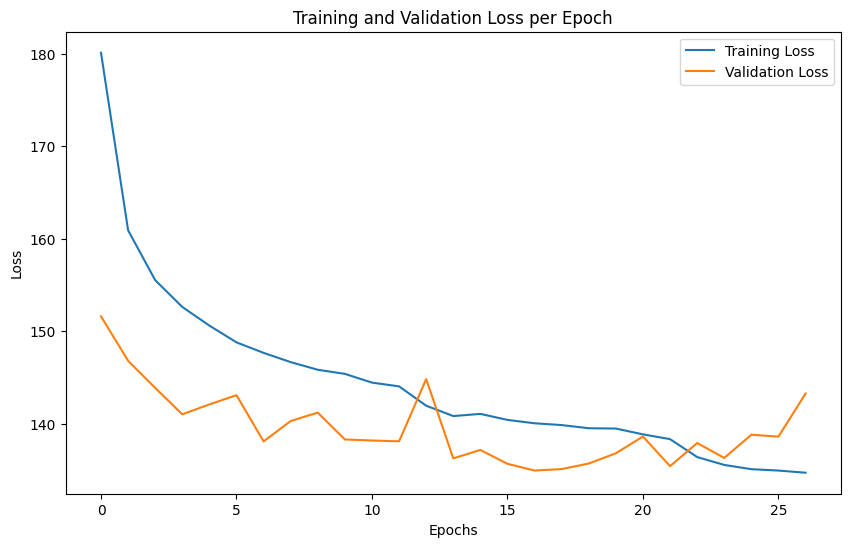

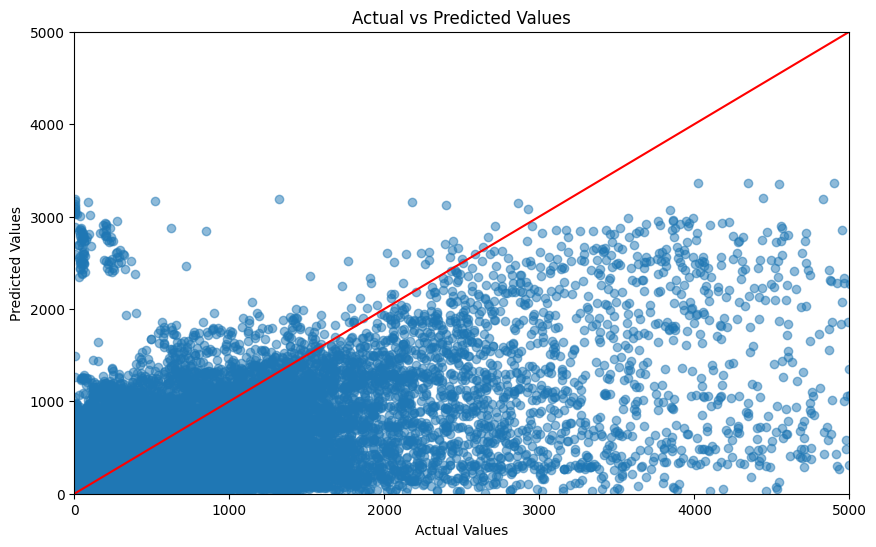

In [110]:
actuals_transformers, predictions_transformers = plot_results(train_losses = train_losses_transformers, val_losses = val_losses_transformers, model_type = "Transformers", model = model_transformers)

### LSTM

Train the LSTM model

In [111]:
model_LSTM, train_losses_LSTM, val_losses_LSTM = training_loop(model_type = "LSTM", model = model_LSTM, extra_epoch = 35, train_loader = train_loader, test_loader = test_loader, val_loader = val_loader, epochs=100)#, train_losses = train_losses_LSTM, val_losses = val_losses_LSTM)

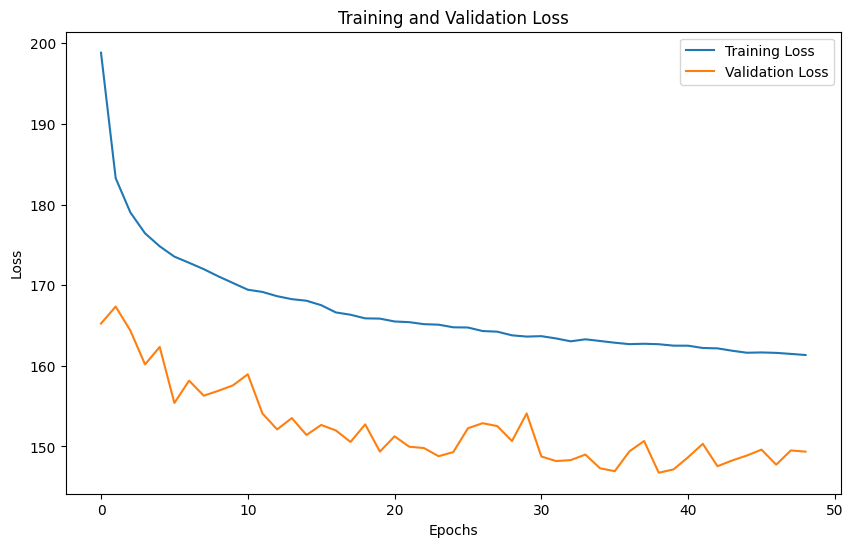

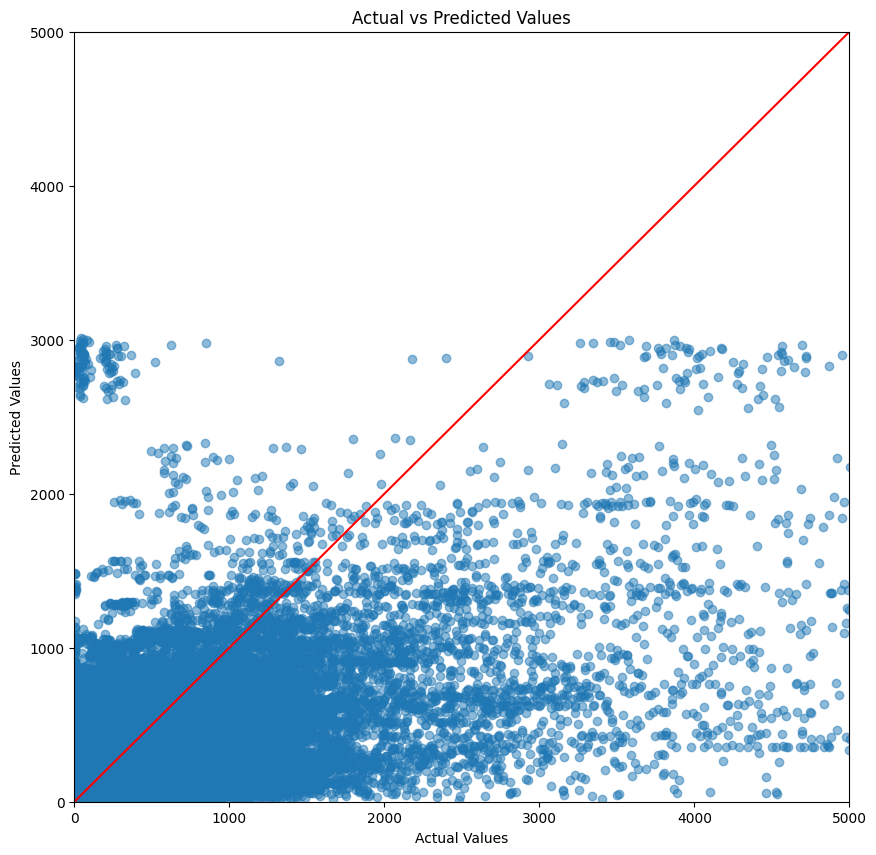

In [112]:
actuals_LSTM, predictions_LSTM = plot_results(train_losses = train_losses_LSTM, val_losses = val_losses_LSTM, model_type = "LSTM", model = model_LSTM)

### Predictions

#### Transformers Predictions

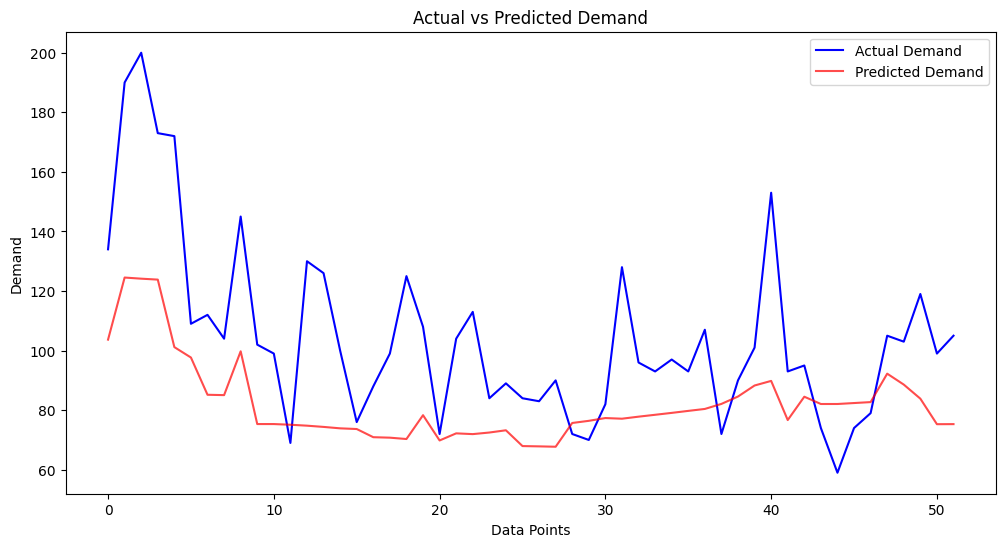

Mean Relative Error: 0.21745130825469783


In [123]:
predictions_forecast_transformers, mae_transformers = validation(model_type = "Transformers", model = model_transformers, forecast_loader = forecast_loader, y_forecast = y_forecast)

#### LSTM Predictions

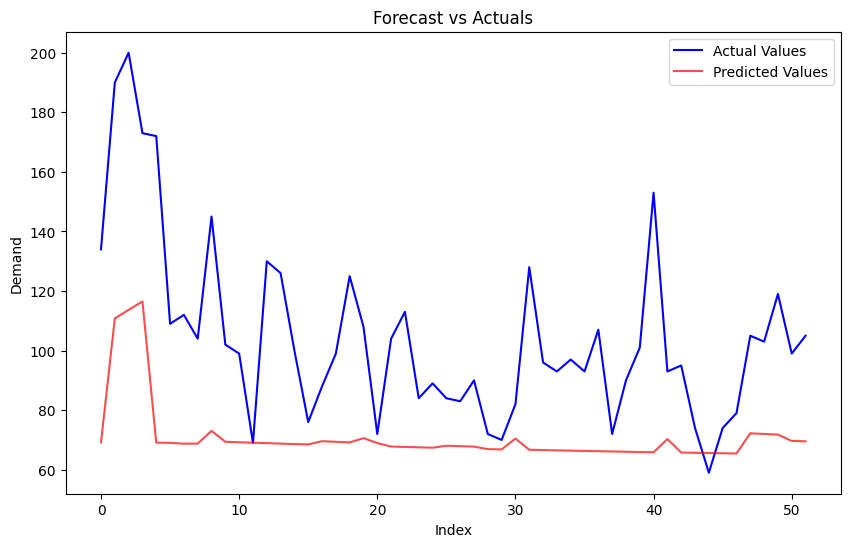

Mean Relative Error: 0.29294442171040297


In [136]:
predictions_forecast_LSTM, mae_LSTM = validation(model_type = "LSTM", model = model_LSTM, forecast_loader = forecast_loader, y_forecast = y_forecast)

#### ARIMA Predictions

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=2148.442, Time=40.25 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=2260.834, Time=0.20 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=2202.085, Time=12.84 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=2147.318, Time=27.31 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=2166.196, Time=0.70 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=inf, Time=69.06 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=inf, Time=106.45 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=2155.509, Time=21.53 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=inf, Time=152.71 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=2249.665, Time=13.80 sec
 ARIMA(0,1,2)(0,1,1)[52]             : AIC=2148.579, Time=44.73 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=2195.926, Time=30.11 sec
 ARIMA(1,1,2)(0,1,1)[52]             : AIC=2150.695, Time=56.92 sec
 ARIMA(0,1,1)(0,1,1)[52] intercept   : AIC=2147.425, Time=59.26 sec

Best model:  ARIMA(

c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: V

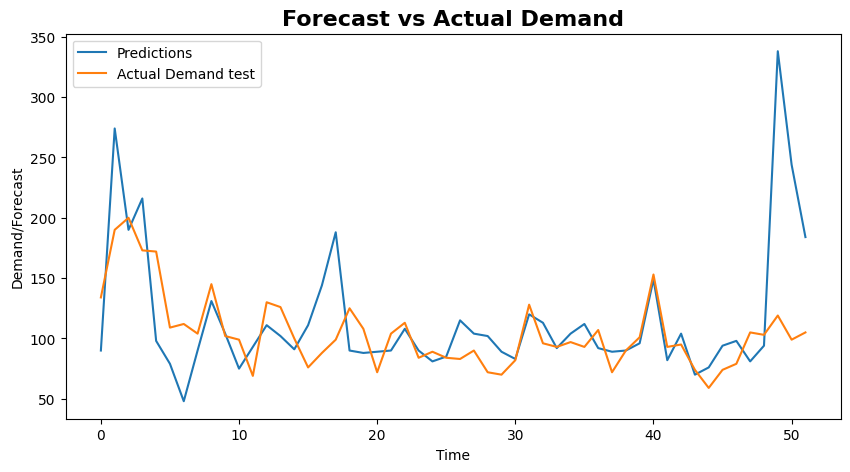

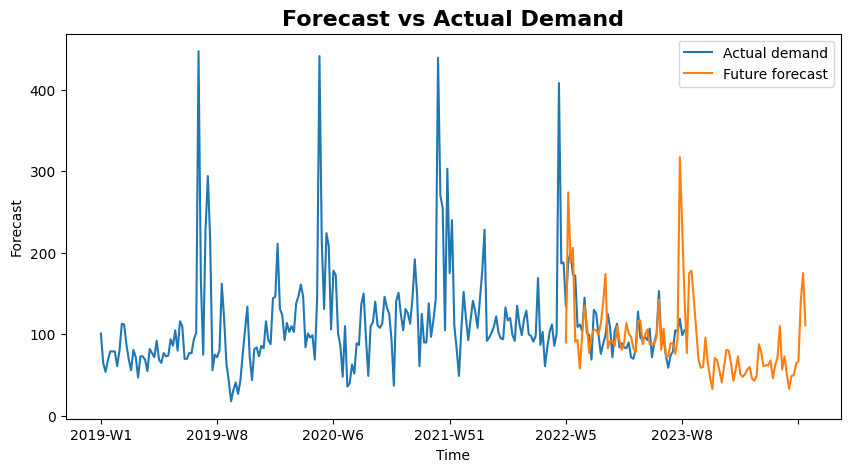

Mean Relative Error: 0.27542803195110555


In [77]:
predictions_forecast_ARIMA, mae_ARIMA = ARIMA()

# Comparison

Comparison of the performance of the three different models

In [121]:
with open('Forecast_pandora_series.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        Forecast_pandora_series = [float(value) for value in row]

Forecast_pandora_series = pd.Series(Forecast_pandora_series, index=index)

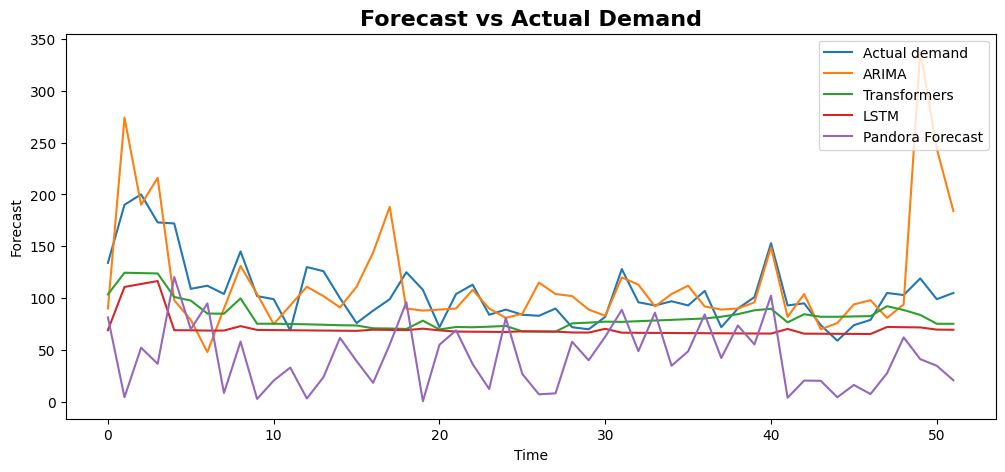

In [135]:
index = y_forecast.index

# Convert lists to Pandas Series
predictions_forecast_transformers_series = pd.Series(predictions_forecast_transformers, index=index)
predictions_forecast_LSTM_series = pd.Series(predictions_forecast_LSTM, index=index)

# Now plot using Pandas plot function
plt.figure(figsize=(12, 5))
y_forecast.reset_index(drop=True).plot(legend=True, label="Actual demand")
predictions_forecast_ARIMA.reset_index(drop=True).plot(label="ARIMA")
predictions_forecast_transformers_series.reset_index(drop=True).plot(label="Transformers")
predictions_forecast_LSTM_series.reset_index(drop=True).plot(label="LSTM")
Forecast_pandora_series.reset_index(drop=True).plot(label="Pandora Forecast")
plt.title("Forecast vs Actual Demand", fontsize=16, fontweight='bold')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Forecast')
plt.show()

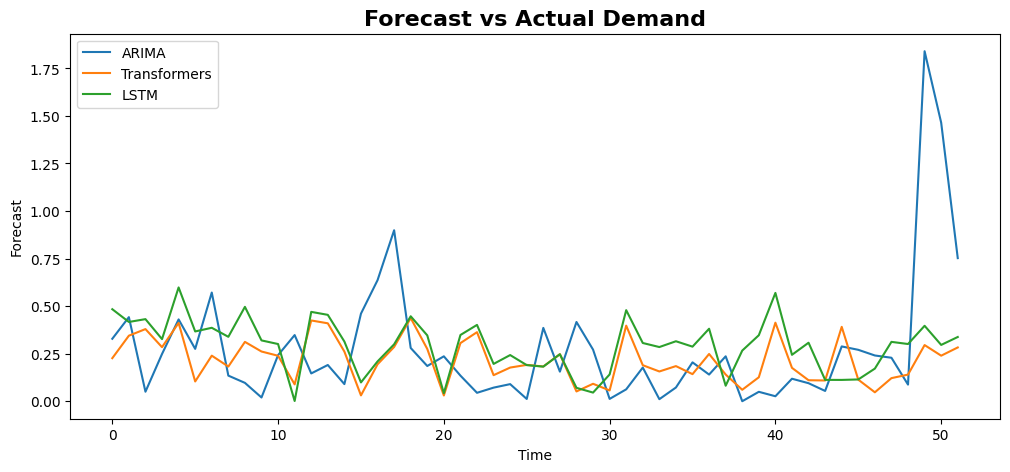

In [107]:
# Difference

ARIMA_diff = (y_forecast.reset_index(drop=True) - predictions_forecast_ARIMA.reset_index(drop=True))/y_forecast.reset_index(drop=True)
Transformers_diff = (y_forecast.reset_index(drop=True) - predictions_forecast_transformers_series.reset_index(drop=True))/y_forecast.reset_index(drop=True)
LSTM_diff = (y_forecast.reset_index(drop=True) - predictions_forecast_LSTM_series.reset_index(drop=True))/y_forecast.reset_index(drop=True)

# Plot difference series
plt.figure(figsize=(12, 5))
ARIMA_diff.abs().plot(label="ARIMA")
Transformers_diff.abs().plot(label="Transformers")
LSTM_diff.abs().plot(label="LSTM")
plt.title("Forecast vs Actual Demand", fontsize=16, fontweight='bold')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Forecast')
plt.show()

# Category evaluation

Evaluation of the model perforamnce for each different product category

Transformers:


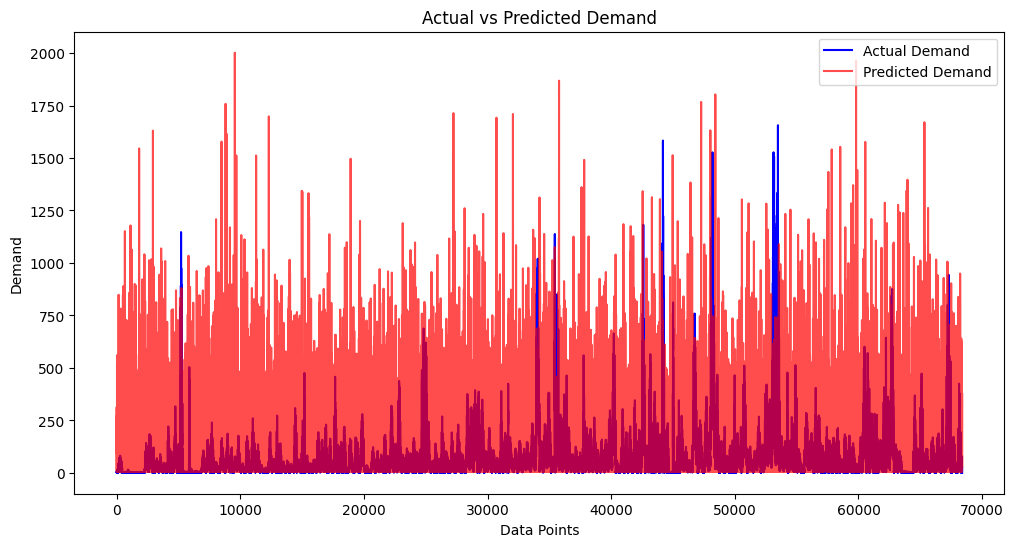

Mean Relative Error: 17.53454205836104
LSTM:


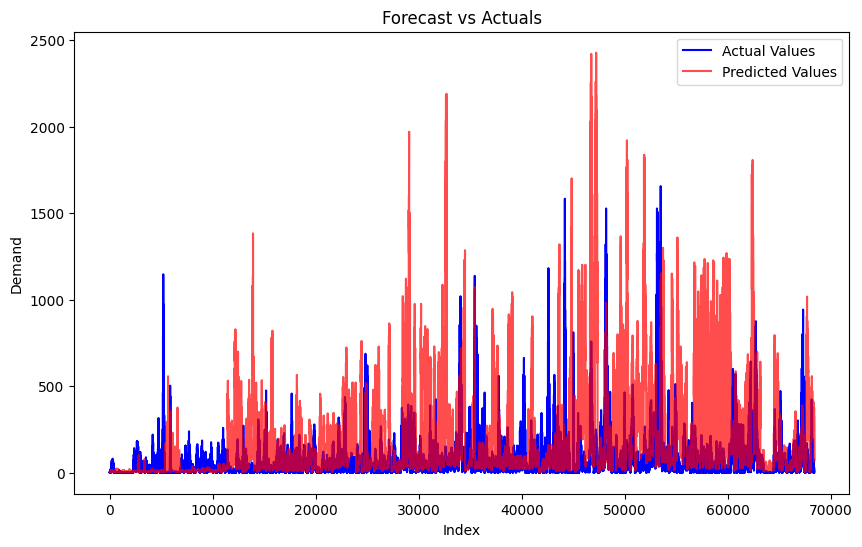

Mean Relative Error: 10.460984779304995
Transformers:


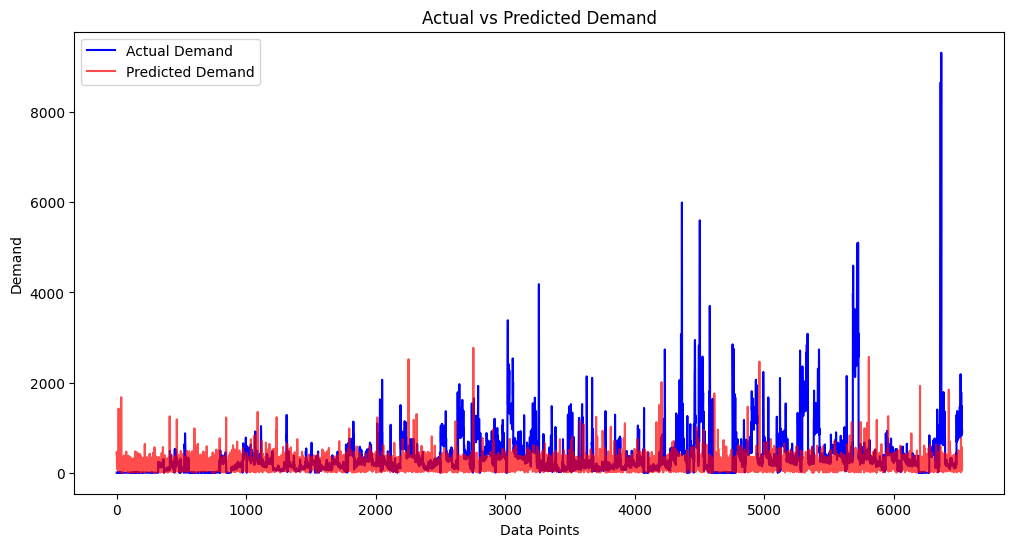

Mean Relative Error: 13.447269860940489
LSTM:


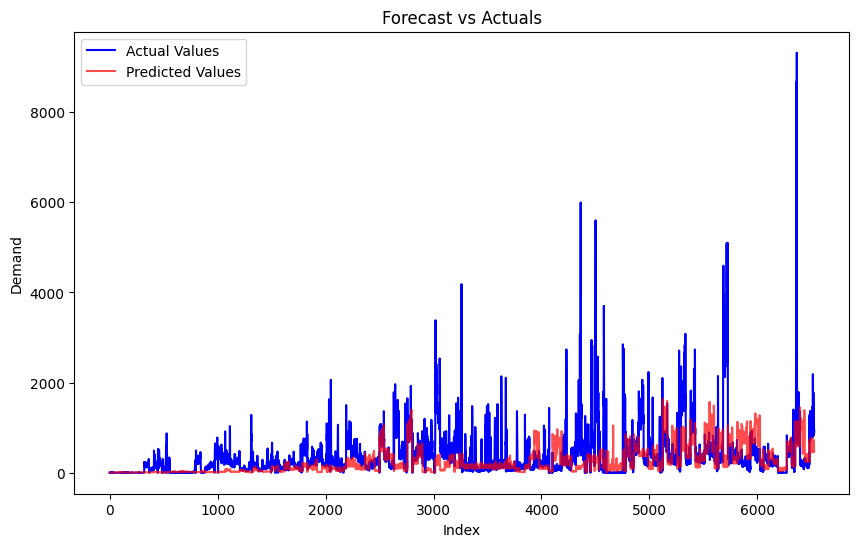

Mean Relative Error: 3.850460822898967
Transformers:


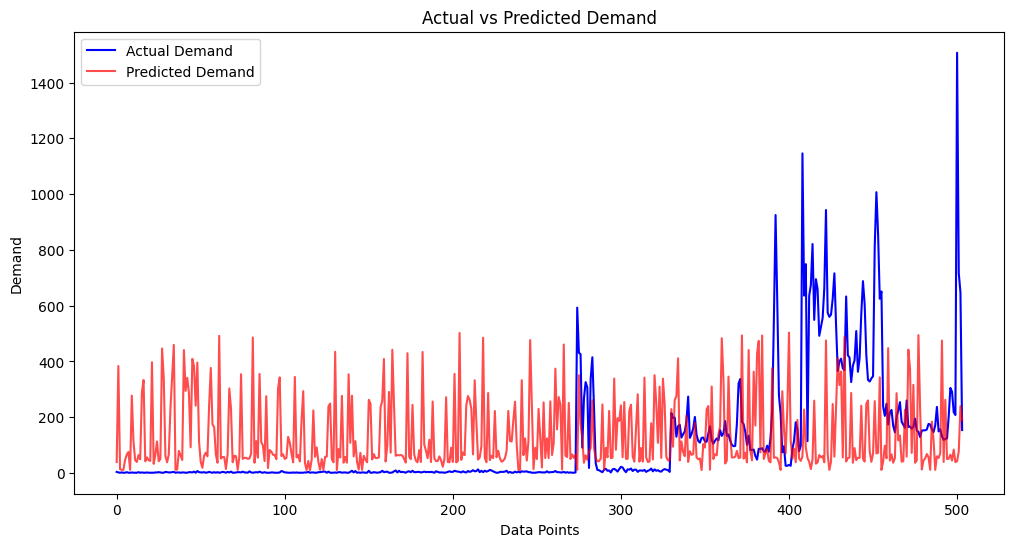

Mean Relative Error: 38.082322250638086
LSTM:


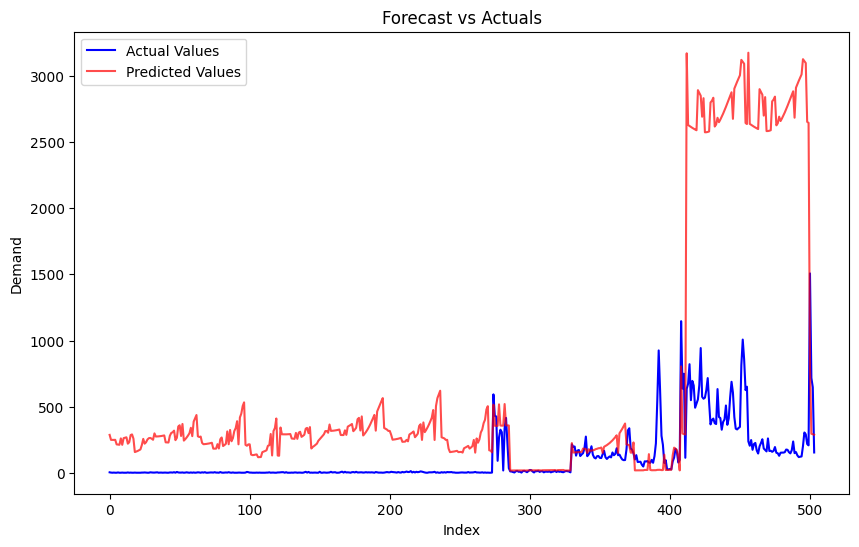

Mean Relative Error: 81.62180982459238
Transformers:


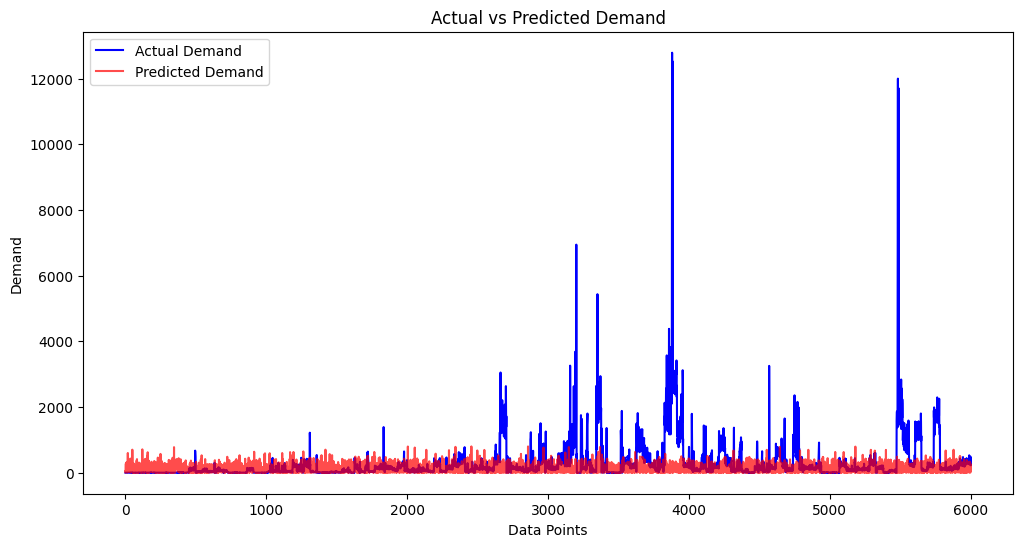

Mean Relative Error: 12.83955007194502
LSTM:


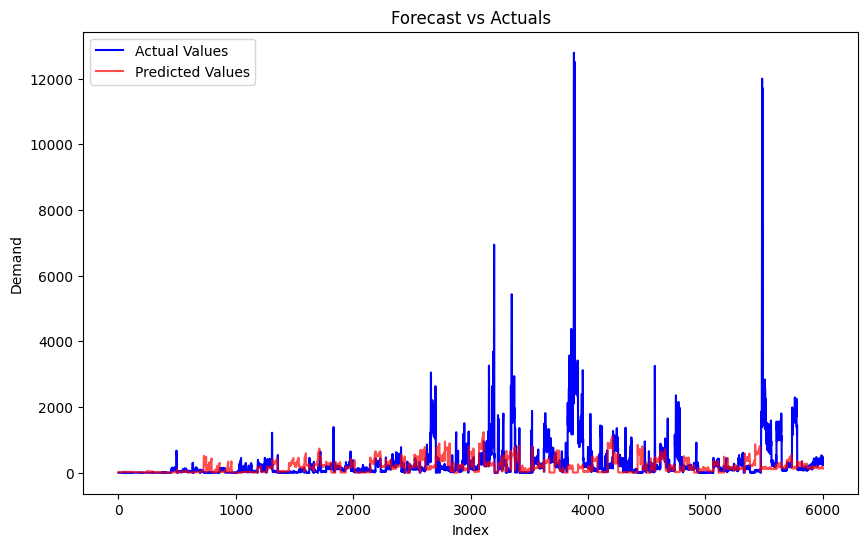

Mean Relative Error: 8.50924597645247
Transformers:


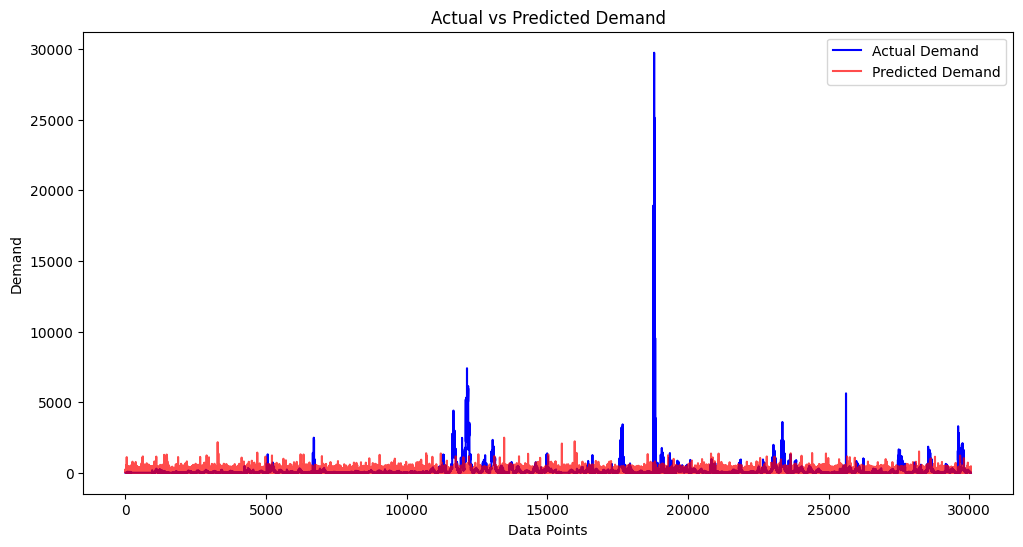

Mean Relative Error: 15.420434925701437
LSTM:


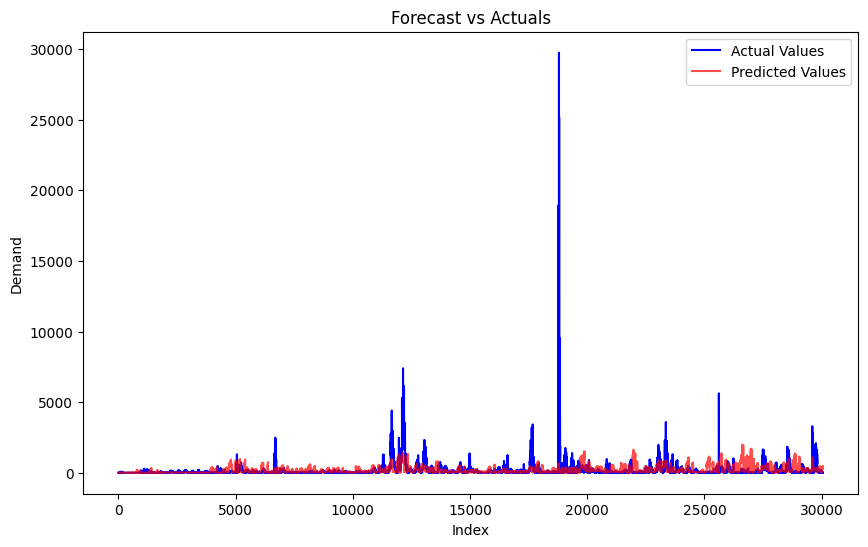

Mean Relative Error: 15.436158913372692
Transformers:


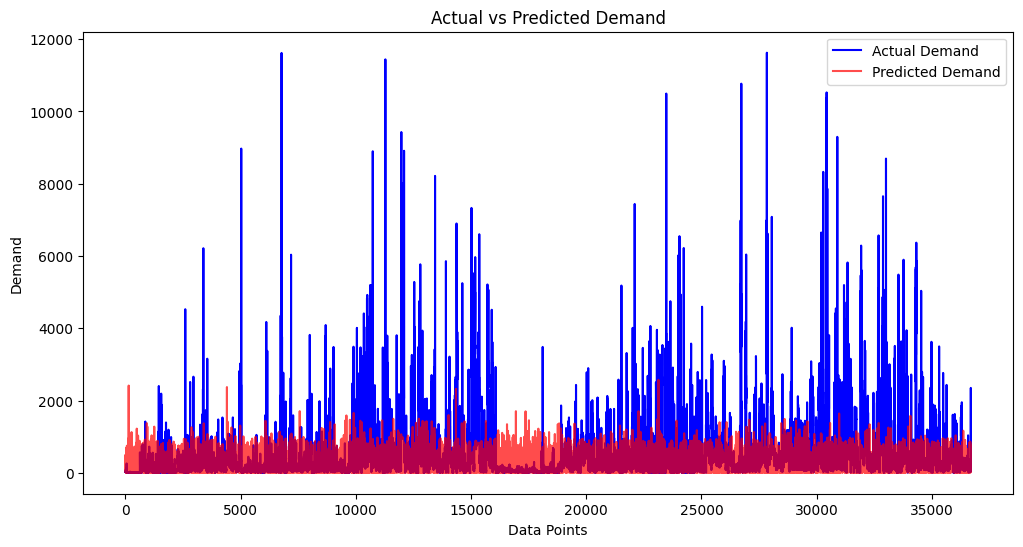

Mean Relative Error: 7.384031432003467
LSTM:


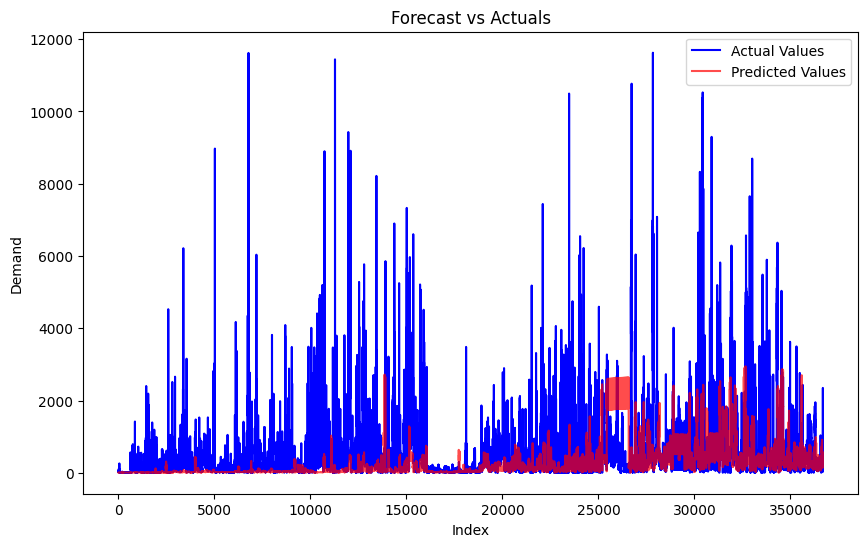

Mean Relative Error: 3.254191719782174
Transformers:


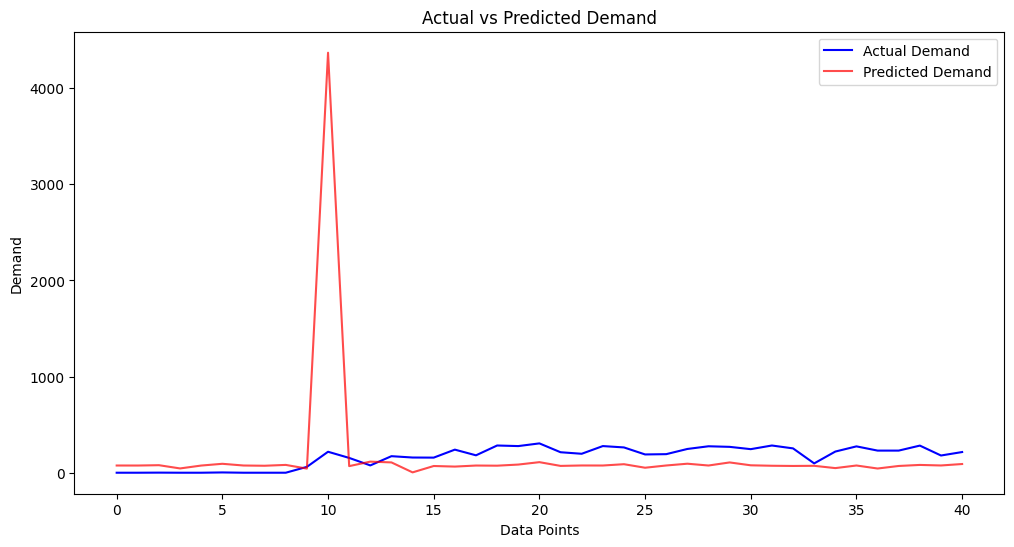

Mean Relative Error: 14.572563339481448
LSTM:


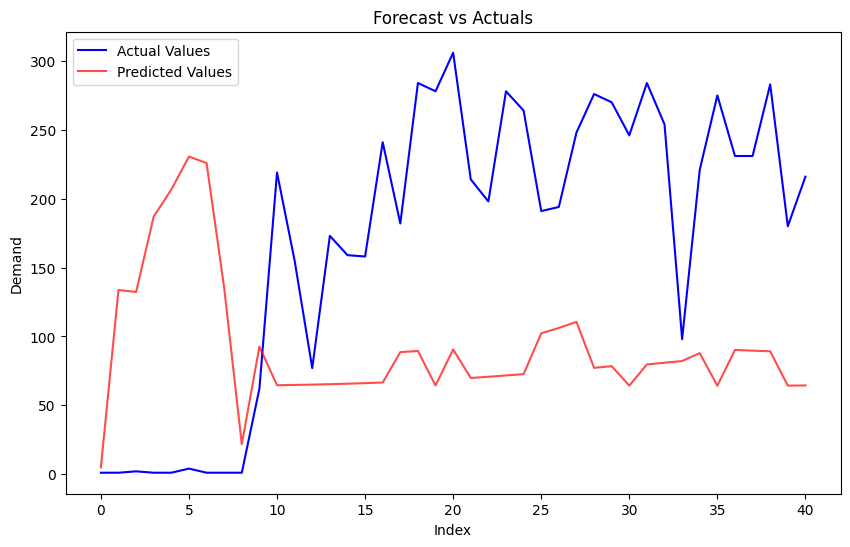

Mean Relative Error: 25.601882481274092
Transformers:


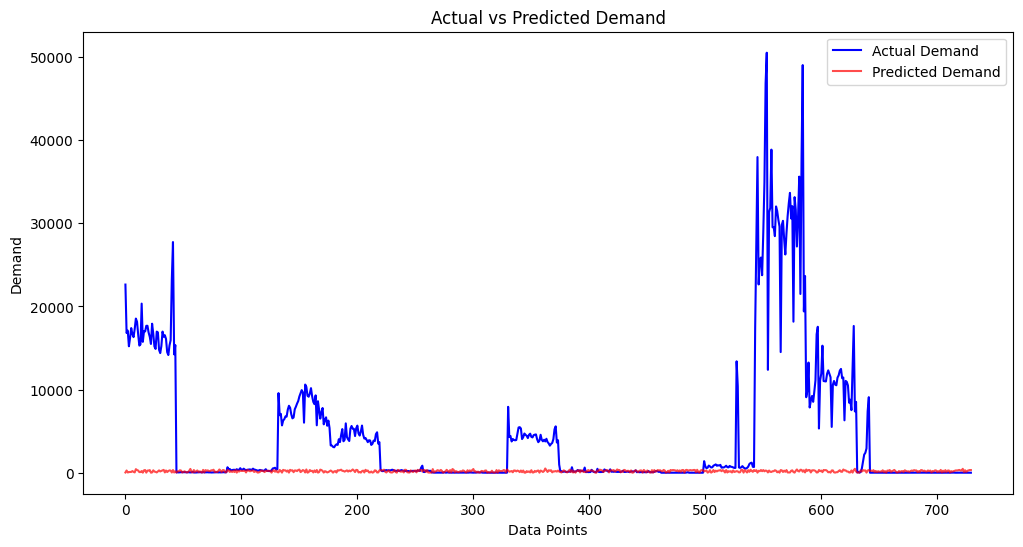

Mean Relative Error: 18.477068020376056
LSTM:


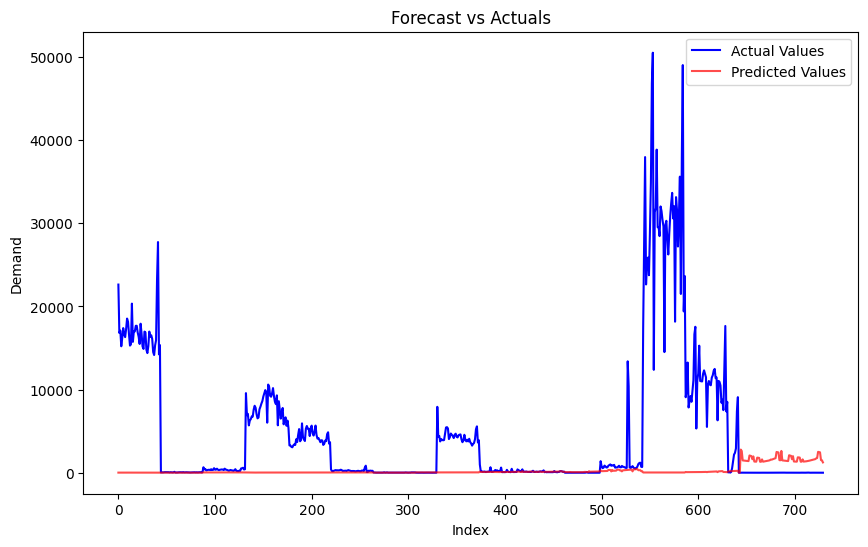

Mean Relative Error: 58.92596738107708


In [124]:
combined_df2 = test 

categories = {}

for category, group in combined_df2.groupby('DNA Category '):
        
        categories[category] = {}

        X = group.drop(columns=['Demand'])
        y = group['Demand']

        X_scaled = scaler.fit_transform(X)

        # Convert to PyTorch tensors
        X_tensor_transformers = torch.tensor(X_scaled, dtype=torch.float32)
        y_tensor_transformers = torch.tensor(y.values, dtype=torch.float32)

        ##
        X_tensor_LSTM = torch.tensor(X_scaled.astype(np.float32))
        y_tensor_LSTM = torch.tensor(y.values.astype(np.float32))
        ##

        # Create Data Loaders
        data_transformers = TensorDataset(X_tensor_transformers, y_tensor_transformers)
        #
        data_LSTM = TensorDataset(X_tensor_LSTM, y_tensor_LSTM)
        #

        loader_transformers = DataLoader(data_transformers, batch_size=128, shuffle=True)
        #
        loader_LSTM = DataLoader(data_LSTM, batch_size=128)
        #

        print('Transformers:')
        predictions_forecast_transformers_category, mre_transformers_category = validation(model_type="Transformers",model=model_transformers,forecast_loader=loader_transformers,y_forecast=y)
        
        print('LSTM:')
        predictions_forecast_LSTM_category, mre_LSTM_category = validation(model_type="LSTM",model=model_LSTM,forecast_loader=loader_LSTM,y_forecast=y)
        
        categories[category]["Transformers"] = [predictions_forecast_transformers_category, mre_transformers_category]
        categories[category]["LSTM"] = [predictions_forecast_LSTM_category, mre_LSTM_category]
        

# Save and load models

In [113]:
torch.save(model_transformers, 'model_transformers.pth')

In [114]:
torch.save(model_LSTM, 'model_LSTM.pth')

In [115]:
model_LSTM = torch.load('model_LSTM.pth')



In [116]:
model_transformers = torch.load('model_transformers.pth')

In [117]:
import csv

# Saving train_losses to a CSV file
# Transformers
with open('train_losses_transformers.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(train_losses_transformers)

with open('val_losses_transformers.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(val_losses_transformers)


In [118]:
# LSTM
with open('train_losses_LSTM.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(train_losses_LSTM)

with open('val_losses_LSTM.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(val_losses_LSTM)

In [ ]:
# Reading train_losses from a CSV file
#Transformers
with open('train_losses_transformers.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        train_losses_transformers = [float(loss) for loss in row]

with open('val_losses_transformers.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        val_losses_transformers = [float(loss) for loss in row]


# LSTM
with open('train_losses_LSTM.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        train_losses_LSTM = [float(loss) for loss in row]

with open('val_losses_LSTM.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        val_losses_LSTM = [float(loss) for loss in row]
